https://rpubs.com/italogoncalves/tempdata3d

# 1  Import and Setup

In [ ]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 10.1 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import visualkeras

from tensorflow.keras.utils import plot_model

from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense, RepeatVector, TimeDistributed, Bidirectional
from keras.callbacks import EarlyStopping

from matplotlib.cm import ScalarMappable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [ ]:
!mkdir -p /content/data

In [ ]:
if not os.path.exists('/content/data/global-historical-climatology-network.zip'):
    !curl -L -o /content/data/global-historical-climatology-network.zip https://www.kaggle.com/api/v1/datasets/download/noaa/global-historical-climatology-network

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4642k  100 4642k    0     0  6084k      0 --:--:-- --:--:-- --:--:-- 6084k


In [ ]:
if not os.path.exists('/content/data/ghcn-m-v1.csv'):
  !unzip /content/data/global-historical-climatology-network.zip -d /content/data

Archive:  /content/data/global-historical-climatology-network.zip
  inflating: /content/data/ghcn-m-v1.csv  


# 2  Preprocessing


In [ ]:
# Load the CSV file
rawdata = pd.read_csv('/content/data/ghcn-m-v1.csv')

In [ ]:
# Reshape the data
procdata = rawdata.melt(id_vars=['year', 'month', 'lat'], var_name='lon', value_name='temp')

# Filter out invalid temperatures
procdata = procdata[procdata['temp'] != -9999]

# Process latitude and longitude
procdata['lat_sign'] = np.where(procdata['lat'].str.contains('S'), -1, 1) # South -> -1, North -> 1
procdata['lon_sign'] = np.where(procdata['lon'].str.contains('W'), -1, 1) # West  -> -1, East  -> 1

# Clean lat and lon columns
procdata['lat'] = procdata['lat'].str.replace('[NS]', '', regex=True)
procdata['lon'] = procdata['lon'].str.replace('[EW]', '', regex=True)
procdata['lon'] = procdata['lon'].str.replace('lon_', '', regex=True)

# Split coordinates and calculate midpoint
procdata[['lat1', 'lat2']] = procdata['lat'].str.split('-', expand=True).astype(float)
procdata[['lon1', 'lon2']] = procdata['lon'].str.split('_', expand=True).astype(float)

procdata['lat'] = procdata['lat_sign'] * (procdata['lat1'] + procdata['lat2']) / 2
procdata['lon'] = procdata['lon_sign'] * (procdata['lon1'] + procdata['lon2']) / 2

# Add time column
procdata['time'] = procdata['year'] + (procdata['month'] - 1) / 12

In [ ]:
# Convert 'year' and 'month' columns to datetime objects
procdata['date'] = pd.to_datetime(procdata[['year', 'month']].assign(day=1)) # .dt.to_period('M') # for YYYY-MM format

procdata = procdata[['date', 'lat', 'lon', 'temp']].reset_index(drop=True)

In [ ]:
# Display detailed information
print(procdata.info())

# Check for unique values in 'date', 'lat', 'lon' columns
print(f"{'Unique months:':<20} {procdata['date'].nunique()}")
print(f"{'Unique latitudes:':<20} {procdata['lat'].nunique()}")
print(f"{'Unique longitudes:':<20} {procdata['lon'].nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2863452 entries, 0 to 2863451
Data columns (total 4 columns):
 #   Column  Dtype         
---  ------  -----         
 0   date    datetime64[ns]
 1   lat     float64       
 2   lon     float64       
 3   temp    int64         
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 87.4 MB
None
Unique months:       1641
Unique latitudes:    38
Unique longitudes:   72


In [ ]:
# procdata.to_csv('procdata.csv', index=False)
procdata

,date,lat,lon,temp
0,1880-01-01,27.5,-177.5,-7
1,1880-01-01,22.5,-177.5,-44
2,1880-01-01,17.5,-177.5,-48
3,1880-01-01,-12.5,-177.5,-15
4,1880-01-01,-17.5,-177.5,44
...,...,...,...,...
2863447,2016-09-01,-37.5,177.5,66
2863448,2016-09-01,-42.5,177.5,23
2863449,2016-09-01,-47.5,177.5,-1
2863450,2016-09-01,-52.5,177.5,-13


# 3 Global Monthly Mean Temprature Anomalies  

## Obtain the data

In [ ]:
# Group by year and month, then calculate the mean temperature for each group
global_monthly_mean = procdata.groupby(['date'])['temp'].mean().reset_index()

# Rename the column
global_monthly_mean = global_monthly_mean.rename(columns={'temp': 'global_monthly_mean_temp'})

In [ ]:
global_monthly_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641 entries, 0 to 1640
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      1641 non-null   datetime64[ns]
 1   global_monthly_mean_temp  1641 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 25.8 KB


In [ ]:
global_monthly_mean

,date,global_monthly_mean_temp
0,1880-01-01,-44.930750
1,1880-02-01,-56.910184
2,1880-03-01,-66.274477
3,1880-04-01,-54.772563
4,1880-05-01,-47.154472
...,...,...
1636,2016-05-01,47.013235
1637,2016-06-01,51.040533
1638,2016-07-01,47.991043
1639,2016-08-01,51.963542


In [ ]:
print(f"{'Starting date: ':<15} {procdata['date'].dt.to_period('M').min()}")
print(f"{'Ending date: ':<15} {procdata['date'].dt.to_period('M').max()}")

Starting date:  1880-01
Ending date:    2016-09


## Visualization

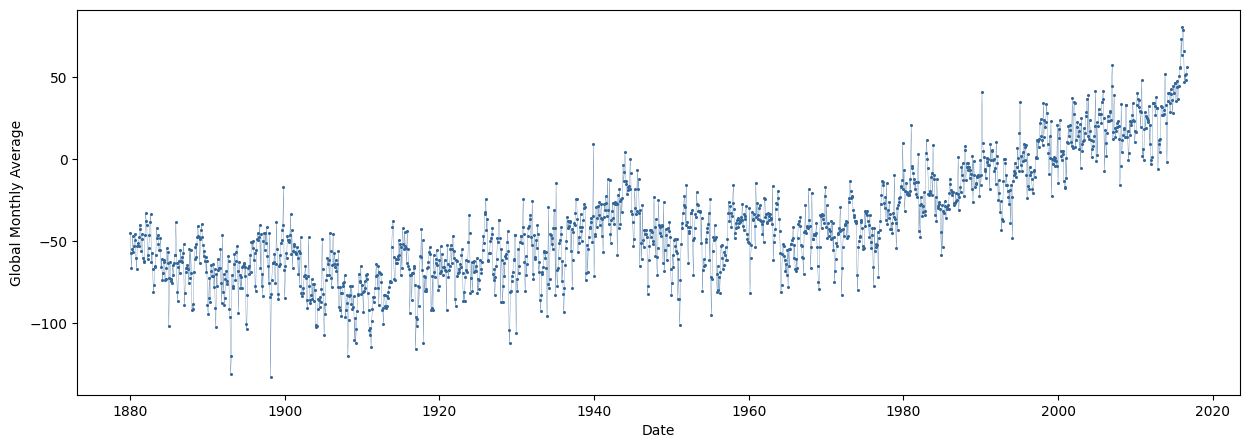

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(global_monthly_mean['date'],
         global_monthly_mean['global_monthly_mean_temp'],
         color='#336699',  # Line color
         # alpha=0.5,        # Line transparency
         linestyle='-',    # Line style
         linewidth=0.2,
         markersize=1.2,
         marker='o',       # Marker style
         markerfacecolor='#003366',  # Marker fill color
)
plt.xlabel('Date')
plt.ylabel('Global Monthly Average')
# plt.title('Global Monthly Average Temperature Over Time')
plt.show()

## Data preparation

In [ ]:
# Define some hyperparameters
data_to_use = global_monthly_mean

# Time data bing x and the y the dependent variale
x , y = 'date', 'global_monthly_mean_temp'

train_size = 0.80
seq_size = 12 # 30

print(data_to_use.describe())

                                date  global_monthly_mean_temp
count                           1641               1641.000000
mean   1948-05-01 13:48:22.376599680                -39.917914
min              1880-01-01 00:00:00               -132.803481
25%              1914-03-01 00:00:00                -65.026911
50%              1948-05-01 00:00:00                -45.682968
75%              1982-07-01 00:00:00                -20.202681
max              2016-09-01 00:00:00                 80.182281
std                              NaN                 34.538044


In [ ]:
train, test = train_test_split(data_to_use, train_size=train_size, shuffle=False) # Split without suffling

print(f"{'Train data: ': <15}\n{train.describe()}")
print(f"{'Test size: ': <15}\n{test.describe()}")

Train data:    
                                date  global_monthly_mean_temp
count                           1312               1312.000000
mean   1934-08-16 15:30:43.902439040                -53.095127
min              1880-01-01 00:00:00               -132.803481
25%              1907-04-23 12:00:00                -68.682451
50%              1934-08-16 12:00:00                -53.066473
75%              1961-12-08 18:00:00                -37.658137
max              1989-04-01 00:00:00                 20.542407
std                              NaN                 22.665230
Test size:     
                                date  global_monthly_mean_temp
count                            329                329.000000
mean   2002-12-31 09:59:38.115501568                 12.630729
min              1989-05-01 00:00:00                -47.931139
25%              1996-03-01 00:00:00                 -1.427984
50%              2003-01-01 00:00:00                 11.988211
75%              2009-1

In [ ]:
# Normalize the dataset
scaler = MinMaxScaler() # StandardScaler() # standardize features by removing the mean and scaling to unit variance
scaler = scaler.fit(train[[y]])



> Best practice to fit the scaler on the training data only and then use that fitted scaler to transform both the training and test data to ensures that the test data remains unseen during the training process, which helps to avoid data leakage and provides a more realistic evaluation of the model's performance.



In [ ]:
# Apply the transformation
train[y] = scaler.transform(train[[y]])
test[y] = scaler.transform(test[[y]])

In [ ]:
print(f"{'Train data: ': <15}\n{train.describe()}")
print(f"{'Test size: ': <15}\n{test.describe()}")

Train data:    
                                date  global_monthly_mean_temp
count                           1312               1312.000000
mean   1934-08-16 15:30:43.902439040                  0.519795
min              1880-01-01 00:00:00                  0.000000
25%              1907-04-23 12:00:00                  0.418146
50%              1934-08-16 12:00:00                  0.519981
75%              1961-12-08 18:00:00                  0.620462
max              1989-04-01 00:00:00                  1.000000
std                              NaN                  0.147805
Test size:     
                                date  global_monthly_mean_temp
count                            329                329.000000
mean   2002-12-31 09:59:38.115501568                  0.948406
min              1989-05-01 00:00:00                  0.553470
25%              1996-03-01 00:00:00                  0.856727
50%              2003-01-01 00:00:00                  0.944216
75%              2009-1

In [ ]:
def to_sequences(x, y, seq_size=1):
    x_values, y_values = [], []

    for i in range(len(x)-seq_size):
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])

    return np.array(x_values), np.array(y_values)


trainX, trainY = to_sequences(train[[y]], train[y], seq_size)
testX, testY = to_sequences(test[[y]], test[y], seq_size)

print(f"trainX shape: {trainX.shape}")
print(f"trainY shape: {trainY.shape}")
print(f"testX shape: {testX.shape}")
print(f"testY shape: {testY.shape}")

trainX shape: (1300, 12, 1)
trainY shape: (1300,)
testX shape: (317, 12, 1)
testY shape: (317,)


## Model definition

In [ ]:
input_shape = (trainX.shape[1], trainX.shape[2])  # Define input shape

In [ ]:
model = Sequential(
    [
        Input(shape=input_shape),               # Input layer
        LSTM(128, return_sequences=False),      # First LSTM layer (encoder)
        Dropout(0.2),                           # Dropout layer
        RepeatVector(trainX.shape[1]),          # RepeatVector layer
        LSTM(128, return_sequences=True),       # Second LSTM layer (decoder)
        Dropout(0.2),                           # Dropout layer
        TimeDistributed(Dense(trainX.shape[2])),    # TimeDistributed Dense layer
    ],
    name="lstm-autoencoder"
)

model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "lstm-autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 12, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 12, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 12, 1)               │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Fit model with the EarlyStopping callback
history = model.fit(
    trainX, trainY,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],  # Add the callback here
    shuffle=False
)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.2233 - val_loss: 0.1126
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0957 - val_loss: 0.0840
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0922 - val_loss: 0.0741
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0943 - val_loss: 0.0794
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0955 - val_loss: 0.0854
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.1022 - val_loss: 0.1526


In [ ]:
# Save the best model weights
# model.save_weights(f"/content/{model.name}_weights.weights.h5")

In [ ]:
# Assuming 'model' is defined as in the provided code.  Replace with actual path if different.
# model.load_weights('/content/lstm-autoencoder_weights.weights.h5')

In [ ]:
# Save the training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/training_history.csv', index=False)

# Load the training history
loaded_history_df = pd.read_csv('/content/training_history.csv')


# Example: Accessing saved history data
print(loaded_history_df.head())

       loss  val_loss
0  0.159327  0.112608
1  0.096832  0.084036
2  0.091256  0.074074
3  0.090020  0.079443
4  0.092760  0.085425


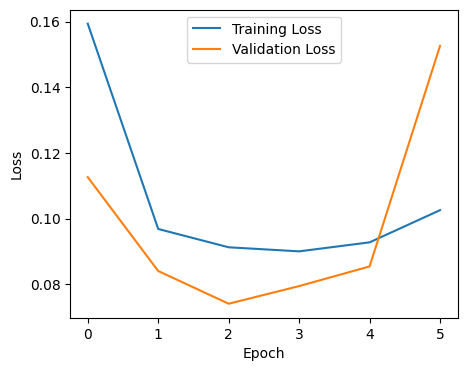

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.title(f'Training and Validation Loss for {model.name}') # Add model name as title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Prediction and Analysis

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


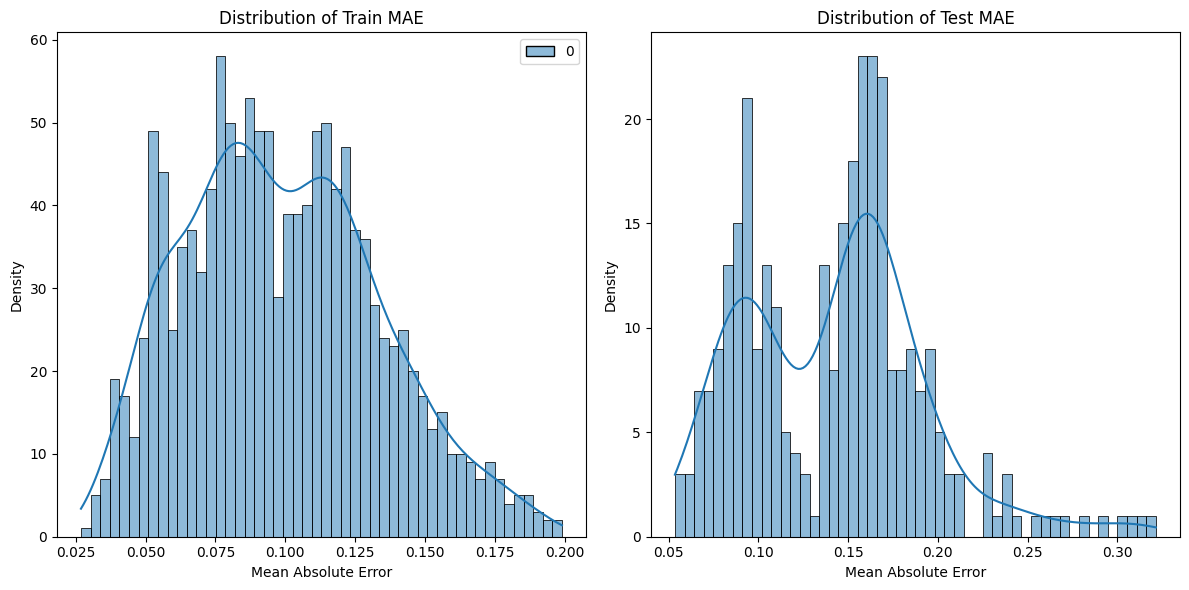

In [ ]:
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)

testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot Train MAE distribution on the first subplot
sns.histplot(trainMAE, bins=50, ax=axes[0], kde=True, legend=True)
axes[0].set_xlabel('Mean Absolute Error')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of Train MAE')

# Plot Test MAE distribution on the second subplot
sns.histplot(testMAE, bins=50, ax=axes[1], kde=True, legend=False)
axes[1].set_xlabel('Mean Absolute Error')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of Test MAE')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

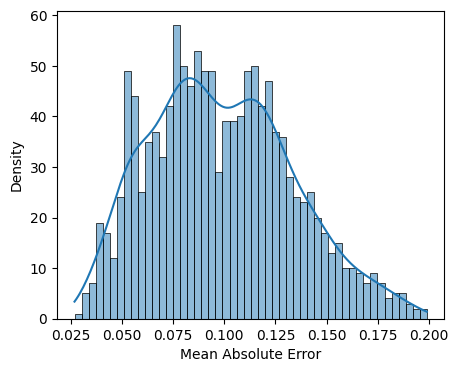

In [ ]:
# Create a figure and axes
fig, axes = plt.subplots(1, 1, figsize=(5, 4))

# Plot Train MAE distribution
sns.histplot(trainMAE, bins=50, ax=axes, kde=True, legend=False)

# Set x and y labels for the current axes
axes.set_xlabel('Mean Absolute Error')  # Call set_xlabel on axes
axes.set_ylabel('Density')  # Call set_ylabel on axes

# Show the plot
plt.show()

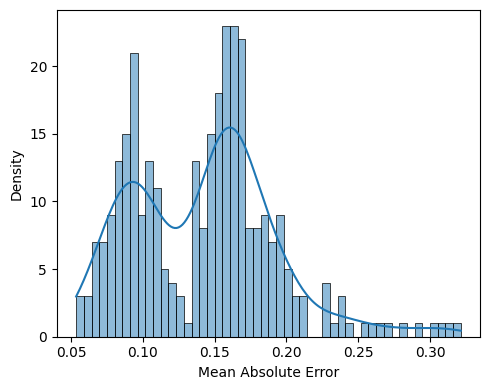

In [ ]:
# Create a figure and axes
fig, axes = plt.subplots(1, 1, figsize=(5, 4))


# Plot Test MAE distribution
sns.histplot(testMAE, bins=50, ax=axes, kde=True, legend=False)
axes.set_xlabel('Mean Absolute Error')
axes.set_ylabel('Density')


plt.tight_layout()
plt.show()

In [ ]:
max_train_mae = np.max(trainMAE)
print(f"Maximum Train MAE: {max_train_mae}")

THERESHOLD = max_train_mae * 0.95
print(f"Thereshold: {THERESHOLD}")

Maximum Train MAE: 0.1989030587312136
Thereshold: 0.1889579057946529


In [ ]:
# Creat a new dataframe
test_score_df = pd.DataFrame(test[seq_size:], columns=[x])
test_score_df['testMAE'] = testMAE
test_score_df['threshold'] = THERESHOLD
test_score_df['anomaly'] = test_score_df['testMAE'] > test_score_df['threshold']
test_score_df[y] = test[y]

In [ ]:
print(test_score_df)

           date   testMAE  threshold  anomaly  global_monthly_mean_temp
1324 1990-05-01  0.070464   0.188958    False                  0.895793
1325 1990-06-01  0.075754   0.188958    False                  0.873766
1326 1990-07-01  0.082598   0.188958    False                  0.826389
1327 1990-08-01  0.086997   0.188958    False                  0.816961
1328 1990-09-01  0.092259   0.188958    False                  0.789841
...         ...       ...        ...      ...                       ...
1636 2016-05-01  0.294461   0.188958     True                  1.172622
1637 2016-06-01  0.301318   0.188958     True                  1.198885
1638 2016-07-01  0.306489   0.188958     True                  1.178998
1639 2016-08-01  0.315750   0.188958     True                  1.204904
1640 2016-09-01  0.321483   0.188958     True                  1.232565

[317 rows x 5 columns]


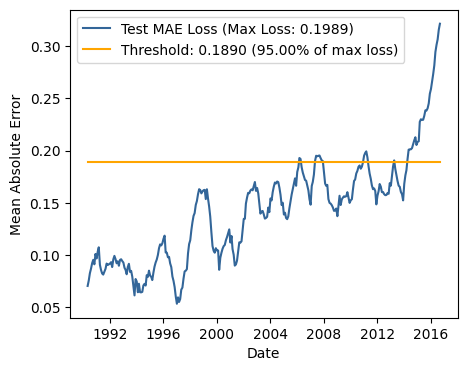

In [ ]:
# Plote testMAE vs. max_trainMAE
plt.figure(figsize=(5, 4))
plt.plot(test_score_df['date'], test_score_df['testMAE'], label=f"Test MAE Loss (Max Loss: {max_train_mae:.4f})", color='#336699')
plt.plot(test_score_df['date'], test_score_df['threshold'], label=f"Threshold: {THERESHOLD:.4f} ({THERESHOLD / max_train_mae * 100:.2f}% of max loss)", color='orange')
plt.xlabel('Date')
plt.ylabel('Mean Absolute Error')
# plt.title('Test MAE vs Max Train MAE')
plt.legend()
plt.show()

In [ ]:
# prompt: modify the above graph by changing the lable of the the second plot buy puting the value of the treshold and percentate * maximum loss as will, and the maximum loss in the other label

# ... (Your existing code)

# Plote testMAE vs. max_trainMAE
plt.figure(figsize=(5, 4))
plt.plot(test_score_df['date'], test_score_df['testMAE'], label='Test MAE Loss', color='#336699')

# Calculate the threshold value and maximum loss
threshold_value = THERESHOLD
max_loss = max_train_mae

# Modify the label for the second plot
plt.plot(test_score_df['date'], test_score_df['threshold'],
         label=f"Threshold: {threshold_value:.4f} ({threshold_value / max_loss * 100:.2f}% of max loss)\nMax Loss: {max_loss:.4f}",
         color='orange')

plt.xlabel('Date')
plt.ylabel('Mean Absolute Error')
# plt.title('Test MAE vs Max Train MAE')
plt.legend()
plt.show()

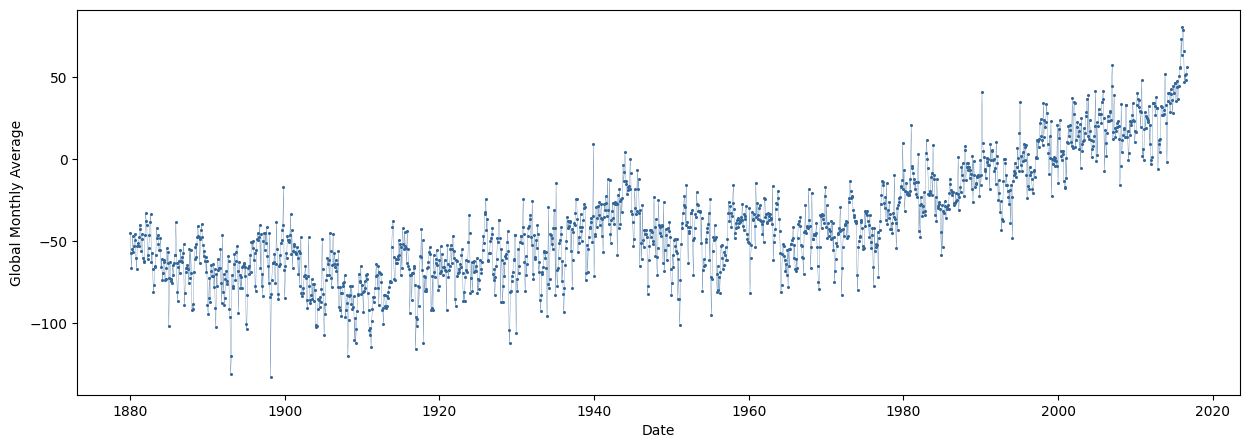

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(global_monthly_mean['date'],
         global_monthly_mean['global_monthly_mean_temp'],
         color='#336699',  # Line color
         # alpha=0.5,        # Line transparency
         linestyle='-',    # Line style
         linewidth=0.2,
         markersize=1.2,
         marker='o',       # Marker style
         markerfacecolor='#003366',  # Marker fill color
)
plt.xlabel('Date')
plt.ylabel('Global Monthly Average')
# plt.title('Global Monthly Average Temperature Over Time')
plt.show()

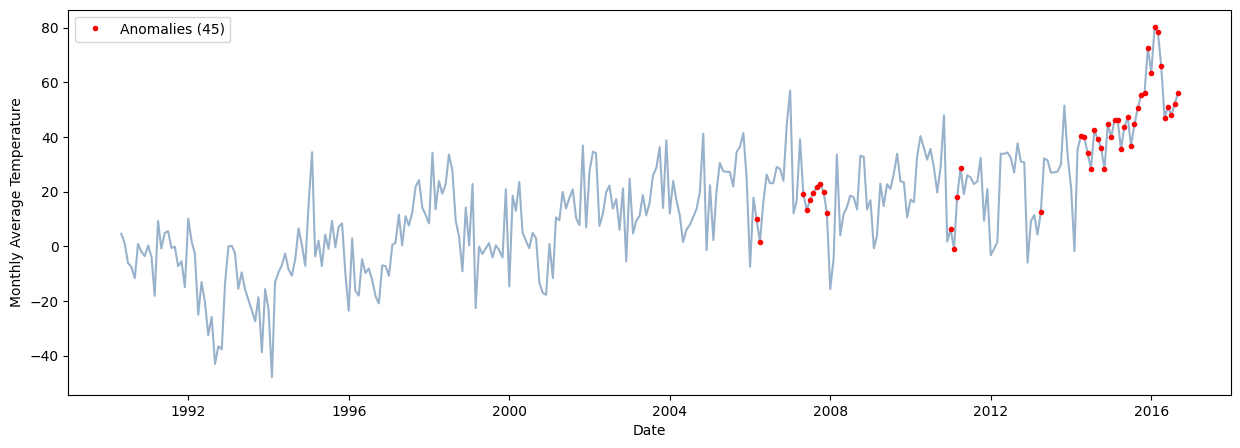

In [ ]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]

plt.figure(figsize=(15, 5))
plt.plot(test[seq_size:][[x]],
         scaler.inverse_transform(test[seq_size:][[y]]),
         color='#336699',
         alpha=0.5
         )
plt.plot(anomalies[x],
         scaler.inverse_transform(anomalies[[y]]),
         'ro',
         markersize=3,
         label=f"Anomalies ({len(anomalies)})")
# sns.scatterplot(x=anomalies[x], y=scaler.inverse_transform(anomalies[[y]])[:, 0], color=sns.color_palette()[3], label=f"Anomalies ({len(anomalies)})")
plt.xlabel('Date')
plt.ylabel('Monthly Average Temperature')
# plt.title('Anomalies in Monthly Average Temperature')
plt.legend()
plt.show()